In [1]:
from graphnics import *
from xii import *

from numpy import loadtxt
import scipy.interpolate as sp_interpolate
import matplotlib.pyplot as plt

%matplotlib notebook
import seaborn as sns
sns.set()
from mpl_toolkits.mplot3d import Axes3D

import sys
sys.path.append('../')

%config InlineBackend.figure_format = 'retina'

Missing HsMG for fract norm computing


# Introduction

Cerebrospinal Fluid (CSF) is known to circulate around and inside the brain, and recent research suggests that its bulk flow might play a crucial role in the brain's waste management system. However, the driving forces for CSF flow are still not well understood.

One interesting observation is that cerebral blood vessels have Perivascular Spaces (PVSs), which are open, annular channels surrounding the blood vessel. These spaces may act as low-resistance highways for fluid flow, which could explain how modest pressure gradients can drive CSF circulation.

The video below shows tracer particles suspended in CSF moving through a perivascular space. Fluid movement appears to be closely linked to arterial wall motion, leading to the hypothesis that arterial pulsations drive bulk flow of CSF through the brain.

In [2]:
from IPython.display import IFrame
IFrame(src="https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-018-07318-3/MediaObjects/41467_2018_7318_MOESM5_ESM.mov", width=500, height=300)

# Simulating pulsatile PVS flow

In this demo we show how to use `graphnics` to simulate pulsatile fluid flow in real network geometries. In particular, we want to simulate CSF flow through the PVS driven by arterial pulsations.

The simulation setup is similar to that proposed in [2] and [3, Section 3.4], now performed on more complex vascular networks.

## Reading a vasculature dataset

For the simulations we use data provided by Timothy Secomb's group. Their datasets are structured as follows:

| Segment  |  | Node  | Node  | diam.  | length | node_from | | | node_to | | |
|---|---|---|---|---|---|---|---|---|---|---|---| 
| **No.** | **name**  | **from**  | **to**  |   |   | **x** | **y** |  **z** |  **x** |  **y** | **z**  |
|  1 | A1 |    1 |   2 |   15.5 | 344.27 |   170.0  |  0.0  |213.0  | 95.0  | 336.0 | 213.0
|  2 | A2 |    2 |   3 |   13.5 | 109.66 |    95.0  | 336.0 |213.0  |107.0 | 445.0  |213.0
|  3 | A3 |    3 |   4 |   16.5 |  90.14 |   107.0  |445.0  |213.0  | 57.0 | 520.0 | 213.0
|  ... | .. |   .. |   .. |   .. | ... |  ... | .. |  .. |   .. |   .. |

with the node position, edge lengths and edge diameters given in micrometer.

The function `get_graph` loops over the rows of this datafile, adding for each row the corresponding edge, the vertices (and vertex positions) belonging to this edge and the vessel radius. 

The `rattm93a`, `rattm93b` and `rattm98_0` are from carcinomas in rats, and contain 14, 27 and 103 edges, respectively.

In [3]:
urls = ['https://physiology.arizona.edu/sites/default/files/rattm93a.txt',
       'https://physiology.arizona.edu/sites/default/files/rattm93b.txt',
       'https://physiology.arizona.edu/sites/default/files/rattum98_0.txt']
        
from data.secomb_tumours import read_network
G = read_network.get_graph(urls[2])
G.make_mesh(4)

Downoading data from https://physiology.arizona.edu/sites/default/files/rattum98_0.txt 

Please visit https://physiology.arizona.edu/people/secomb/network for information on how to cite the source for this data
  


We can plot the network to see what it looks like:

<IPython.core.display.Javascript object>


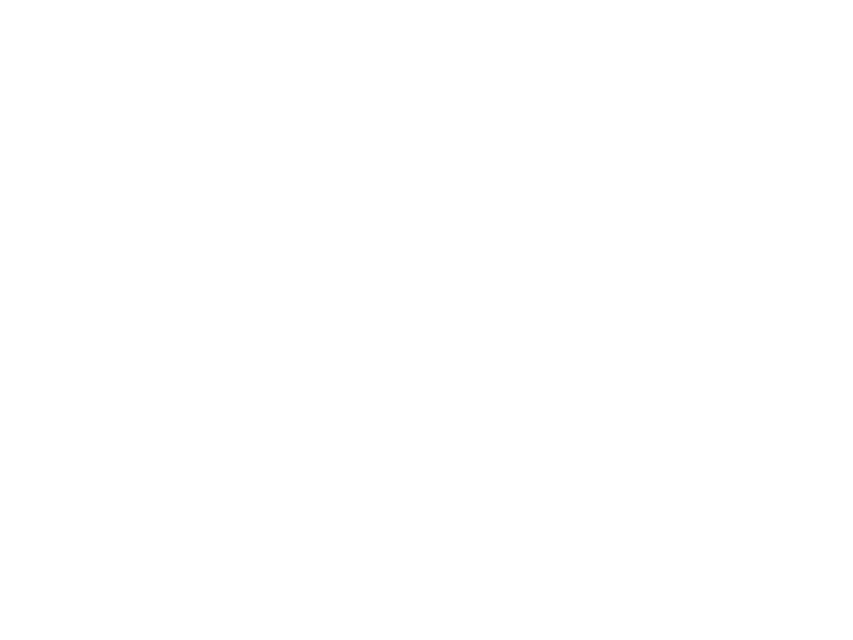

Text(0.5, 0, 'y [$\\mu$m]')

In [4]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

pos = nx.get_node_attributes(G, 'pos')
for e in G.edges():
    u, v = e
    edge_xyz = np.array((pos[u], pos[v]))
    radius = G.edges()[e]['radius']
    ax.plot(*edge_xyz.T, color="tab:red", linewidth=radius*0.3)

plt.xlabel('x [$\mu$m]')
plt.ylabel('y [$\mu$m]')

### Rescaling

We rescale the datapoints so that we are working in mm and the blood vessels radius of the same order of magnitued as in the video above.

In [5]:
for v in G.nodes():
    G.nodes()[v]['pos'] = np.asarray(G.nodes()[v]['pos'])*10e-3

for e in G.edges():
    G.edges()[e]['radius']*=10e-3
    G.edges()[e]['pvs_radius'] = 3*G.edges()[e]['radius']

# Remesh so that it fits the new node positions
G.make_mesh(4)

## Wall motion data

Cardiac wall motion is assigned using `RelDeltaD`-data from [1,2] for the relative change in arterial diameter over time:
$$
\Delta R(s,t)=-\frac{R}{2} \text{RelDeltaD}(t)
$$
In [2,3], cardiac wall motion was modelled as a travelling wave with wave speed 1 m/s. Our domain is, however, only a few millimeters wide. With this in mind we here neglect the effect of travelling cardiac waves.

### Mathematical model

The reduced model solves a time-dependent *Stokes-Brinkman* [3,4] equation for the cross-section flux $\hat{q}_i$ and average pressure $\hat{p}_i$ on each branch of the network:

\begin{align}
\partial_t q_i + \mathcal{R}_i q_i  - \frac{\mu}{A} \partial_{ss}q+   \partial_s p_i   =0  \text{ on } \Lambda_i\\
\partial_s q_i = f_i  \text{ on } \Lambda_i .
\end{align}
where
$$
f_i = 2\pi R_1 w_i
$$
and $\bar{w}_i$ is the wall speed, $A$ is the area of the cross-section and $\nu$ is the kinematic fluid viscosity. Note that we used that $\partial_{ss} q_i =\partial_s f_i=0$ to reduce the Stokes-Brinkman equation to a hydraulic network model.

The resistance $\mathcal{R}_i(s,t)$ is a lumped parameter [4, 5]
$$
\mathcal{R}_i(s,t) = \frac{\nu}{Q_{vp}}
$$
where $Q_{vp}(s,t)=A(s,t)\bar{\bar{v}}_{vp}(s,t)$ is defined as the velocity profile cross-section flux. Modelling the perivascular space as an annular cylinder with radius $R_2=3R_1$, $R_1$ being the arterial radius, the velocity profile cross-section flux is given by [5]
$$
Q_{vp} = R_1^4 \frac{\pi}{8} \left( \alpha^2 -1 - \frac{2(\alpha^2-1)^2}{\ln(\alpha)} \right)
$$
with $\alpha=R_2/R_1$.

At the bifurcation points we impose conservation of mass, $\sum_{i \in E_{in}(n)} \hat{q}_i =\sum_{i \in E_{out}(n)} \hat{q}_i$, and continuity of the averaged normal stress. For more details on model we refer to [3, Section 2.6].

### Driving force
The wall speed $\bar{w}$ acts as a source term in the model. The wall speed is created using data from [1] for the cardiac wall motion. 

Text(0.5, 1.0, 'Relative radius change over time')

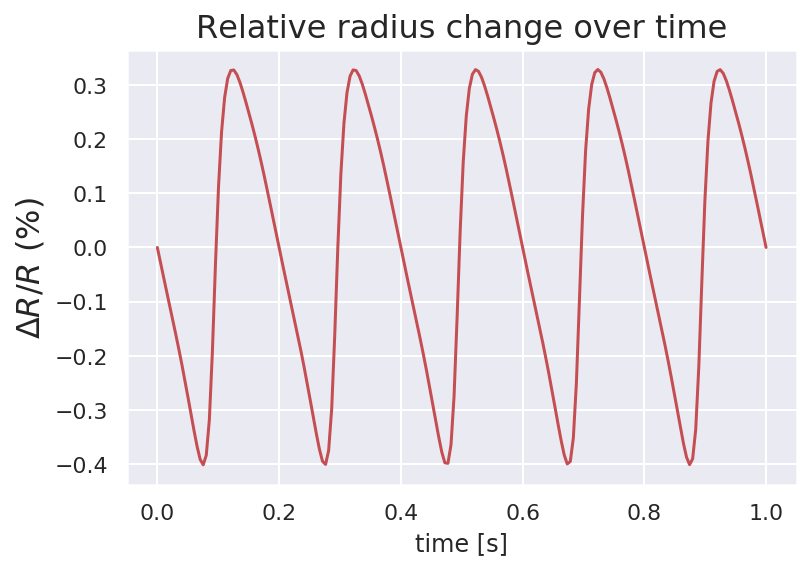

In [6]:
sns.set_theme(style='darkgrid')

data_csv = loadtxt('../data/mestre_wall_motion/wall_motion.dat')
x_data_refined, y_data_refined = data_csv
fdata = sp_interpolate.interp1d(x_data_refined, y_data_refined)

cycle_duration = 0.2 

def RelDeltaD(_t):
    # Data is given in percent for one cardiac cycle , x \in [0,1]
    return fdata((_t/cycle_duration)%1)*0.01

def DeltaR(_t, R):
    return 0.5*R*RelDeltaD(_t)

ts = np.linspace(0, 5*cycle_duration, 200)
%matplotlib inline
plt.plot(ts, RelDeltaD(ts)*100*0.5, 'r')
plt.xlabel('time [s]')
plt.ylabel('$\Delta R/R$ (%)', fontsize=16)
plt.title('Relative radius change over time', fontsize=16)

### Representing wall motion source term in FEniCS

The wall speed can be computed from the radius by the relation
$$
w = 2\pi R \partial_t R. 
$$

The wall speed is then implemented in the model as a `FenicsFunction`:

In [7]:
# Construct radius function from edge radius values
def partial_R(t, R):
    deltat = 1e-3
    return 2.0*np.pi*R*(DeltaR(t+deltat, R)-DeltaR(t-deltat, R))/(2*deltat)


class Radius(UserExpression):
    def __init__(self, G, **kwargs):
        self.G = G
        super().__init__(**kwargs)
    def eval_cell(self, value, x, cell):
        edge_ix = self.G.mf[cell.index]
        edge = list(G.edges())[edge_ix]
        value[0] = self.G.edges()[edge]['radius']


class F(UserExpression):
    def __init__(self, G, t, **kwargs):
        self.G = G
        self.t = t
        super().__init__(**kwargs)
    def eval_cell(self, value, x, cell):
        edge_ix = self.G.mf[cell.index]
        edge = list(G.edges())[edge_ix]
        
        R0 = self.G.edges()[edge]['pvs_radius']
        w = partial_R(self.t, R0)
        
        value[0] = 2*np.pi*R0*w
        
f = F(G, t=0, degree=2)

### Assigning network flow parameters

The resistance and cross-section area are assigned as edge parameters in the `FenicsGraph` representing the network.

As CSF has essentially the same properties as water, we further assign viscosity and density as in water.

In [8]:
mu, rho = water_properties['mu'], water_properties['rho']

alpha = 3
def resistance(R):
    Q = -(3.14/8) *(alpha**2-1-(2*(alpha**2-1)**2)/(np.log(alpha)))
    return mu/(Q*R**4)

for e in G.edges():
    radius1 = G.edges()[e]['radius']
    radius2 = G.edges()[e]['pvs_radius']
    
    G.edges()[e]['Res'] = Constant(resistance(radius1))
    G.edges()[e]['Ainv'] = Constant(1/(np.pi*radius2**2-np.pi*radius1**2))
    
class Radius(UserExpression):
    def __init__(self, G, **kwargs):
        self.G = G
        super().__init__(**kwargs)
    def eval_cell(self, value, x, cell):
        edge_ix = self.G.mf[cell.index]
        edge = list(G.edges())[edge_ix]
        return G.edges()['radius']

Technically, the cross-section area and resistance both depend on time. We neglect this effect, however, as the blood vessel expansion/contraction yields less than 1% change in relative diameter.


## Running the simulations

The viscous effects are known to be negligible for this model. Ignoring the $\partial_{ss}q_i$ term, the model can be posed as a hydrailic network model instead. The finite element forms corresponding to this simplified network model are implemented in the model class `TimeDepHydraulicNetwork`. We then feed this to a time stepping function `time_stepping_stokes` that solves the flow equations at each time step. As the arterial changes are quite small, we expect negligible differences in the resistance and area over time. With that in mind, we set the `reassemble_lhs` option to be False. In this case only the right-hand side is reassembled, which leads to a significant speed up. 


In [23]:
G.make_submeshes()
model = TimeDepHydraulicNetwork(G, f=f, p_bc=Constant(0))

T = cycle_duration*5
t_steps = 100
sols = time_stepping_stokes(model, t=Constant(0), t_steps=t_steps, T=T, reassemble_lhs=False)

  0%|          | 0/99 [00:00<?, ?it/s]

In [24]:
# Plot solutions in paraview

qfile = File('cardiac/q.pvd')
pfile = File('cardiac/p.pvd')
ffile = File('cardiac/f.pvd')

dt = ts[1]-ts[0]

for i, sol in enumerate(sols[1:]):
    t = dt*i
    
    q,p = sol
    q.rename('q', '0.0')
    qfile << (q, float(t))
    
    p.rename('p', '0.0')
    pfile << (p, float(t))
    
    f.t = (T/20)*i
    fi = interpolate(f, FunctionSpace(G.mesh, 'CG', 1))
    fi.rename('f', '0.0')
    ffile << (fi, float(t))

### Plotting inlet and outlet flow

In the context of perivascular fluid flow it is interesting to visualize CSF movement at the inlets and outlets.

In [25]:
# Identify inlet/outlet

adj_matrix = nx.adj_matrix(G).todense()
inlets_outlets = np.where(np.sum(adj_matrix, axis=1)==0)[0]

i = inlets_outlets[3]

# Get pressure and cross-section flux at this inlet/outlet
p_vals, q_vals, ts = [], [], []
dt = T/t_steps

for ix, sol in enumerate(sols[1:]):

    q,p = sol
    
    pos = G.nodes()[i]['pos']
    p_vals.append(p(pos))
    q_vals.append(q(pos)) 
    ts.append(dt*ix)

Text(0.5, 1.0, 'Cross-section flow')

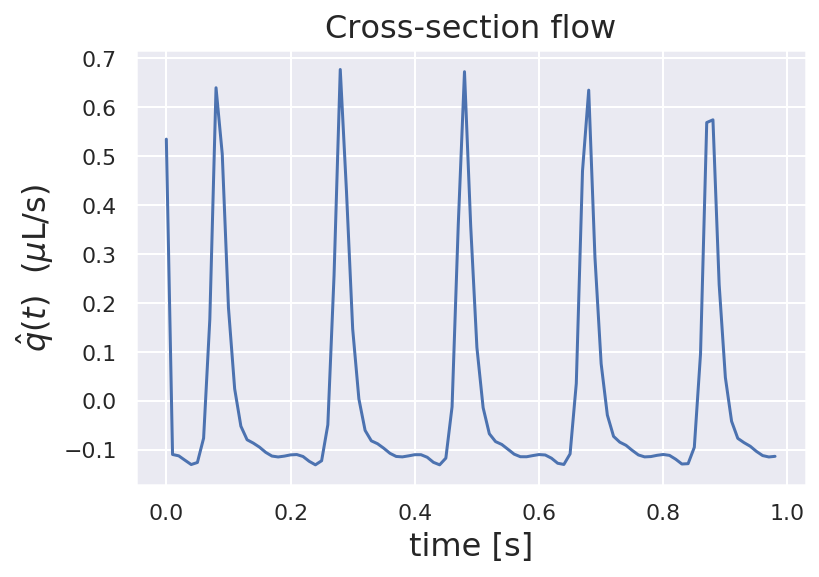

In [26]:
%matplotlib inline
sns.set_theme(style='darkgrid')

plt.figure(figsize=(6,4))
plt.plot(ts, q_vals)
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('$\hat{q}(t)$  ($\mu$L/s)', fontsize=16)
plt.title('Cross-section flow', fontsize=16)

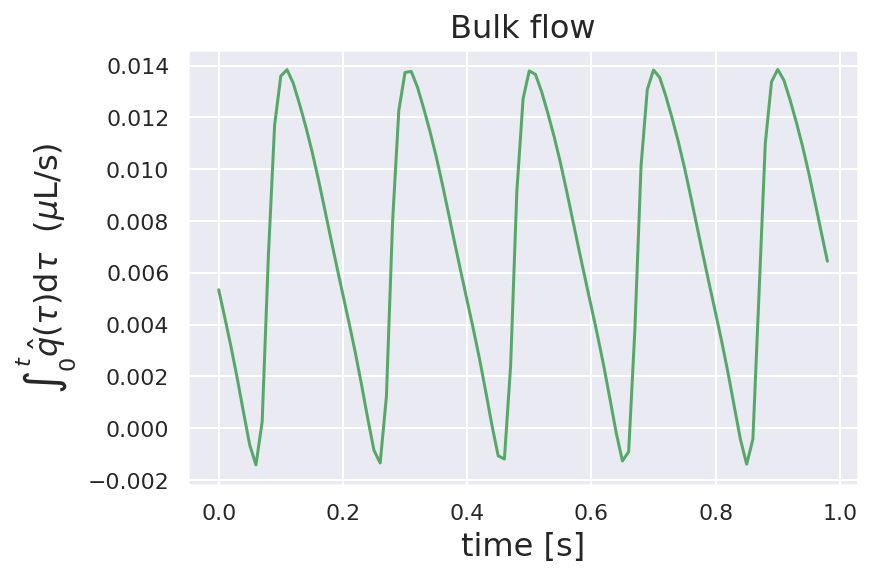

In [27]:
plt.plot(ts, np.cumsum(q_vals)*dt, 'g')
plt.xlabel('time [s]', fontsize=16)
plt.ylabel('$\int_{0}^{t} \hat{q}(\\tau)\mathrm{d}\\tau$  ($\mu$L/s)', fontsize=16)
plt.title('Bulk flow', fontsize=16)
fig.tight_layout()

<IPython.core.display.Javascript object>


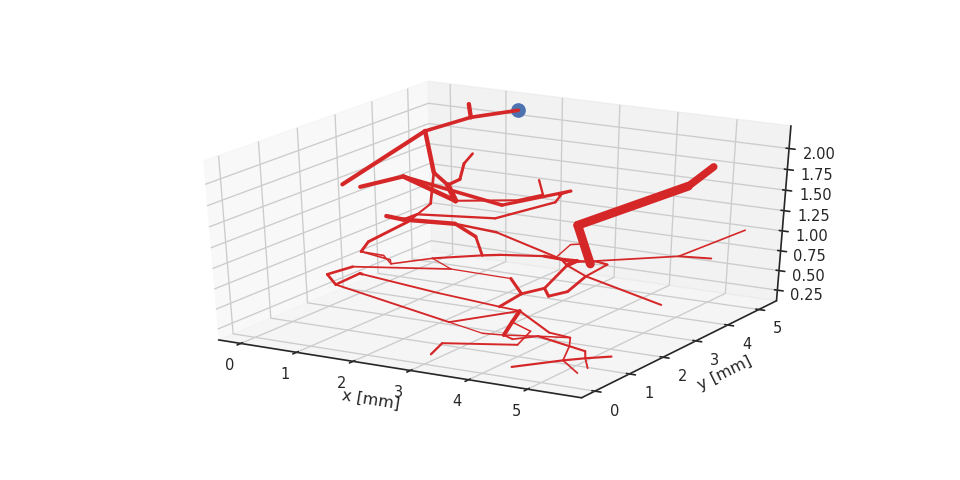

Text(0.5, 0, 'y [mm]')

In [31]:
%matplotlib notebook
sns.set_theme(style='white')

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection="3d")

pos = nx.get_node_attributes(G, 'pos')
for e in G.edges():
    u, v = e
    edge_xyz = np.array((pos[u], pos[v]))
    radius = G.edges()[e]['radius']
    ax.plot(*edge_xyz.T, color="tab:red", linewidth=radius*40)

i = inlets_outlets[1]
pos_i = pos[i]

ax.scatter(*pos_i, s=100)
    
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')

# References

[1] Mestre H, Tithof J, Du T, Song W, Peng W, Sweeney AM, Olveda G, Thomas JH, Nedergaard M, Kelley DH. Flow of cerebrospinal fluid is driven by arterial pulsations and is reduced in hypertension (2018). Nat Commun. 9(1)

[2] Daversin-Catty C, Vinje V, Mardal K-A, Rognes ME (2020) The mechanisms behind perivascular fluid flow. PLoS ONE 15(12): e0244442. https://doi.org/10.1371/journal.pone.0244442

[3] Daversin-Catty C, Gjerde IG, Rognes ME (2022) Geometrically Reduced Modelling of Pulsatile Flow in Perivascular Networks. Frontiers in Physics, 10     

[4] Network models for pulsatile fluid flow in open or porous perivascular spaces. Gjerde I, Rognes ME, Wohlmuth B (in preparation)

[5] Hydraulic resistance of periarterial spaces in the brain. Tithof et al. Fluids Barriers CNS (2019) 16:19